### Import the necessary libraries

In [21]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import numpy as np

In [2]:
np.random.seed(seed=1)

### Load the training data from train.csv file

In [3]:
train_ds = pd.read_csv('train_labels.csv')
print(train_ds.head())

         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127


### Print the shape of the train dataset

In [4]:
print ("Shape of train dataset: ", train_ds.shape)

Shape of train dataset:  (173, 8)


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [5]:
IMAGE_SIZE = 128
TRAIN_CSV = "train_labels.csv"

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [6]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    reader = csv.reader(csvfile, delimiter=',', )
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
        for i, r in enumerate(row[1:8]): # Parse row with seven entities
            if (i != 2):
                row[i+1] = int(r)
              
        path, image_width, image_height, _, x0, y0, x1, y1 = row  
        path = "./images/" + path
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)       

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [7]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    try:
        img = Image.open(f) # Read image
    except:
        print(f)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) 

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [8]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [10]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [11]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
173/173 [==============================] - 5s 31ms/step - loss: 2892.0305 - IoU: 0.0843
Epoch 2/30
173/173 [==============================] - 5s 29ms/step - loss: 681.9701 - IoU: 0.4255
Epoch 3/30
173/173 [==============================] - 5s 29ms/step - loss: 640.8090 - IoU: 0.5312
Epoch 4/30
173/173 [==============================] - 5s 30ms/step - loss: 583.1207 - IoU: 0.5264
Epoch 5/30
173/173 [==============================] - 5s 30ms/step - loss: 352.9757 - IoU: 0.5803
Epoch 6/30
173/173 [==============================] - 5s 32ms/step - loss: 273.2666 - IoU: 0.5736
Epoch 7/30
173/173 [==============================] - 6s 32ms/step - loss: 246.3876 - IoU: 0.6090
Epoch 8/30
173/173 [==============================] - 6s 32ms/step - loss: 197.0070 - IoU: 0.6589
Epoch 9/30
173/173 [==============================] - 6s 33ms/step - loss: 165.8489 - IoU: 0.6997
Epoch 10/30
173/173 [==============================] - 6s 33ms/step - loss: 147.5140 - IoU: 0.7134
Epoch 11/30
173/17

### Pick a test image from the given data

In [14]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = './images/raccoon-41.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [15]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [16]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [17]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

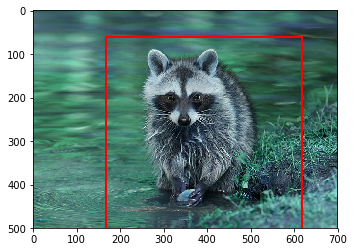

In [20]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Problem 2 : Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [23]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers

#### Mount google drive

In [0]:
#Not required as done in local system

#from google.colab import drive
#drive.mount('/content/drive')

### Load the  data file

In [28]:
df = pd.read_csv('./daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())

            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


### Plot the data

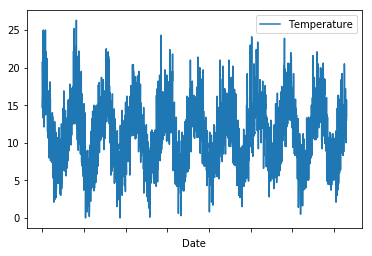

In [29]:
df.plot()

### Check for null values and treat them

In [32]:
# Null Values?
df.isnull().sum()

Temperature    0
dtype: int64

In [33]:
print(df.isnull().any(axis=1).sum())

0


#### Drop null values (if any)

In [34]:
df.dropna(inplace=True)

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A93E919DD8>]],
      dtype=object)

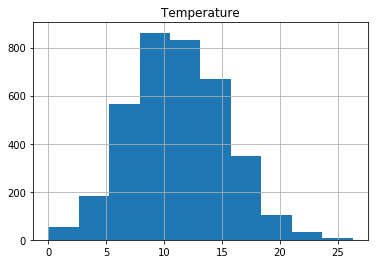

In [35]:
df.hist(bins=10)

### Check the maximum and minimum values

In [36]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [37]:
dataset = df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

### Check the maximum and minimum values of scaled data

In [38]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [39]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [40]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [41]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [42]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

Y 368
0.5779467775742789
368
X 368 to 369
[0.57794678]
Y 369
0.49429659228586964
369
X 369 to 370
[0.49429659]
Y 370
0.4752851848902593
370
X 370 to 371
[0.47528518]
Y 371
0.5361217030607652
371
X 371 to 372
[0.5361217]
Y 372
0.5627376661623434
372
X 372 to 373
[0.56273767]
Y 373
0.6159696286268815
373
X 373 to 374
[0.61596963]
Y 374
0.6007604809535642
374
X 374 to 375
[0.60076048]
Y 375
0.7262357770168689
375
X 375 to 376
[0.72623578]
Y 376
0.8441065173742061
376
X 376 to 377
[0.84410652]
Y 377
0.604562740675857
377
X 377 to 378
[0.60456274]
Y 378
0.49429659228586964
378
X 378 to 379
[0.49429659]
Y 379
0.5361217030607652
379
X 379 to 380
[0.5361217]
Y 380
0.6007604809535642
380
X 380 to 381
[0.60076048]
Y 381
0.9125475549892978
381
X 381 to 382
[0.91254755]
Y 382
0.6844106662419733
382
X 382 to 383
[0.68441067]
Y 383
0.7490494803961542
383
X 383 to 384
[0.74904948]
Y 384
0.9581749617478683
384
X 384 to 385
[0.95817496]
Y 385
0.7794677032200252
385
X 385 to 386
[0.7794677]
Y 386
0.7338

Y 668
0.26615970353854523
668
X 668 to 669
[0.2661597]
Y 669
0.40304185129149267
669
X 669 to 670
[0.40304185]
Y 670
0.2623574256855613
670
X 670 to 671
[0.26235743]
Y 671
0.3612167405165971
671
X 671 to 672
[0.36121674]
Y 672
0.4752851848902593
672
X 672 to 673
[0.47528518]
Y 673
0.5171102956651549
673
X 673 to 674
[0.5171103]
Y 674
0.6730038508137127
674
X 674 to 675
[0.67300385]
Y 675
0.6083650366595319
675
X 675 to 676
[0.60836504]
Y 676
0.42965781439307077
676
X 676 to 677
[0.42965781]
Y 677
0.3992395553078178
677
X 677 to 678
[0.39923956]
Y 678
0.547528518489026
678
X 678 to 679
[0.54752852]
Y 679
0.39163499960185005
679
X 679 to 680
[0.391635]
Y 680
0.34220533312098667
680
X 680 to 681
[0.34220533]
Y 681
0.42205325868710303
681
X 681 to 682
[0.42205326]
Y 682
0.5513308144727008
682
X 682 to 683
[0.55133081]
Y 683
0.6844106662419733
683
X 683 to 684
[0.68441067]
Y 684
0.4866920365799019
684
X 684 to 685
[0.48669204]
Y 685
0.4068441110137856
685
X 685 to 686
[0.40684411]
Y 686
0.3

[0.24334602]
Y 968
0.3193916297417015
968
X 968 to 969
[0.31939163]
Y 969
0.2547528518489026
969
X 969 to 970
[0.25475285]
Y 970
0.31558937001940857
970
X 970 to 971
[0.31558937]
Y 971
0.42585551840939595
971
X 971 to 972
[0.42585552]
Y 972
0.38022814791220744
972
X 972 to 973
[0.38022815]
Y 973
0.38403044389588226
973
X 973 to 974
[0.38403044]
Y 974
0.40304185129149267
974
X 974 to 975
[0.40304185]
Y 975
0.41444866671975333
975
X 975 to 976
[0.41444867]
Y 976
0.21673003705768185
976
X 976 to 977
[0.21673004]
Y 977
0.3612167405165971
977
X 977 to 978
[0.36121674]
Y 978
0.395437259324143
978
X 978 to 979
[0.39543726]
Y 979
0.42205325868710303
979
X 979 to 980
[0.42205326]
Y 980
0.46387833320061667
980
X 980 to 981
[0.46387833]
Y 981
0.40304185129149267
981
X 981 to 982
[0.40304185]
Y 982
0.3346007774150189
982
X 982 to 983
[0.33460078]
Y 983
0.34980988882695446
983
X 983 to 984
[0.34980989]
Y 984
0.2091254813517141
984
X 984 to 985
[0.20912548]
Y 985
0.2699619813915291
985
X 985 to 986


[0.26996198]
Y 1268
0.31558937001940857
1268
X 1268 to 1269
[0.31558937]
Y 1269
0.3269962217090512
1269
X 1269 to 1270
[0.32699622]
Y 1270
0.38403044389588226
1270
X 1270 to 1271
[0.38403044]
Y 1271
0.31558937001940857
1271
X 1271 to 1272
[0.31558937]
Y 1272
0.273764259244513
1272
X 1272 to 1273
[0.27376426]
Y 1273
0.29277566664012333
1273
X 1273 to 1274
[0.29277567]
Y 1274
0.2965779626237982
1274
X 1274 to 1275
[0.29657796]
Y 1275
0.34600762910466154
1275
X 1275 to 1276
[0.34600763]
Y 1276
0.3574144445329222
1276
X 1276 to 1277
[0.35741444]
Y 1277
0.2965779626237982
1277
X 1277 to 1278
[0.29657796]
Y 1278
0.09885931483103574
1278
X 1278 to 1279
[0.09885931]
Y 1279
0.09125475912506797
1279
X 1279 to 1280
[0.09125476]
Y 1280
0.1482889813118991
1280
X 1280 to 1281
[0.14828898]
Y 1281
0.04942965741551787
1281
X 1281 to 1282
[0.04942966]
Y 1282
0.07984790743542537
1282
X 1282 to 1283
[0.07984791]
Y 1283
0.2813688330811717
1283
X 1283 to 1284
[0.28136883]
Y 1284
0.273764259244513
1284
X 128

X 1567 to 1568
[0.36121674]
Y 1568
0.3536121848106293
1568
X 1568 to 1569
[0.35361218]
Y 1569
0.40304185129149267
1569
X 1569 to 1570
[0.40304185]
Y 1570
0.23954374043696708
1570
X 1570 to 1571
[0.23954374]
Y 1571
0.3269962217090512
1571
X 1571 to 1572
[0.32699622]
Y 1572
0.25855514783257744
1572
X 1572 to 1573
[0.25855515]
Y 1573
0.3307984814313441
1573
X 1573 to 1574
[0.33079848]
Y 1574
0.3193916297417015
1574
X 1574 to 1575
[0.31939163]
Y 1575
0.3536121848106293
1575
X 1575 to 1576
[0.35361218]
Y 1576
0.38022814791220744
1576
X 1576 to 1577
[0.38022815]
Y 1577
0.3992395553078178
1577
X 1577 to 1578
[0.39923956]
Y 1578
0.4562737774946489
1578
X 1578 to 1579
[0.45627378]
Y 1579
0.38403044389588226
1579
X 1579 to 1580
[0.38403044]
Y 1580
0.3574144445329222
1580
X 1580 to 1581
[0.35741444]
Y 1581
0.38403044389588226
1581
X 1581 to 1582
[0.38403044]
Y 1582
0.30418251832976595
1582
X 1582 to 1583
[0.30418252]
Y 1583
0.40304185129149267
1583
X 1583 to 1584
[0.40304185]
Y 1584
0.51711029566

X 1867 to 1868
[0.40684411]
Y 1868
0.5399239627830582
1868
X 1868 to 1869
[0.53992396]
Y 1869
0.7414448884288045
1869
X 1869 to 1870
[0.74144489]
Y 1870
0.8136882220275712
1870
X 1870 to 1871
[0.81368822]
Y 1871
0.6806083702582986
1871
X 1871 to 1872
[0.68060837]
Y 1872
0.6615969628626882
1872
X 1872 to 1873
[0.66159696]
Y 1873
0.4828897405962271
1873
X 1873 to 1874
[0.48288974]
Y 1874
0.5247148513711226
1874
X 1874 to 1875
[0.52471485]
Y 1875
0.5323194070770905
1875
X 1875 to 1876
[0.53231941]
Y 1876
0.5703422218683112
1876
X 1876 to 1877
[0.57034222]
Y 1877
0.5513308144727008
1877
X 1877 to 1878
[0.55133081]
Y 1878
0.4980988882695445
1878
X 1878 to 1879
[0.49809889]
Y 1879
0.4334600741153637
1879
X 1879 to 1880
[0.43346007]
Y 1880
0.4752851848902593
1880
X 1880 to 1881
[0.47528518]
Y 1881
0.4562737774946489
1881
X 1881 to 1882
[0.45627378]
Y 1882
0.5095057036978052
1882
X 1882 to 1883
[0.5095057]
Y 1883
0.547528518489026
1883
X 1883 to 1884
[0.54752852]
Y 1884
0.6730038508137127
1884

2167
X 2167 to 2168
[0.47148289]
Y 2168
0.41444866671975333
2168
X 2168 to 2169
[0.41444867]
Y 2169
0.4828897405962271
2169
X 2169 to 2170
[0.48288974]
Y 2170
0.46387833320061667
2170
X 2170 to 2171
[0.46387833]
Y 2171
0.47148288890658446
2171
X 2171 to 2172
[0.47148289]
Y 2172
0.3726235922062397
2172
X 2172 to 2173
[0.37262359]
Y 2173
0.3231939257253763
2173
X 2173 to 2174
[0.32319393]
Y 2174
0.5589353701786686
2174
X 2174 to 2175
[0.55893537]
Y 2175
0.4562737774946489
2175
X 2175 to 2176
[0.45627378]
Y 2176
0.39163499960185005
2176
X 2176 to 2177
[0.391635]
Y 2177
0.4182509627034282
2177
X 2177 to 2178
[0.41825096]
Y 2178
0.3878327036181752
2178
X 2178 to 2179
[0.3878327]
Y 2179
0.47908748087393416
2179
X 2179 to 2180
[0.47908748]
Y 2180
0.4410646660827134
2180
X 2180 to 2181
[0.44106467]
Y 2181
0.3688212962225648
2181
X 2181 to 2182
[0.3688213]
Y 2182
0.5095057036978052
2182
X 2182 to 2183
[0.5095057]
Y 2183
0.3992395553078178
2183
X 2183 to 2184
[0.39923956]
Y 2184
0.55893537017866

2467
X 2467 to 2468
[0.2471483]
Y 2468
0.4562737774946489
2468
X 2468 to 2469
[0.45627378]
Y 2469
0.31558937001940857
2469
X 2469 to 2470
[0.31558937]
Y 2470
0.3307984814313441
2470
X 2470 to 2471
[0.33079848]
Y 2471
0.3307984814313441
2471
X 2471 to 2472
[0.33079848]
Y 2472
0.3878327036181752
2472
X 2472 to 2473
[0.3878327]
Y 2473
0.2623574256855613
2473
X 2473 to 2474
[0.26235743]
Y 2474
0.18631179610311985
2474
X 2474 to 2475
[0.1863118]
Y 2475
0.38022814791220744
2475
X 2475 to 2476
[0.38022815]
Y 2476
0.28897338878713946
2476
X 2476 to 2477
[0.28897339]
Y 2477
0.5513308144727008
2477
X 2477 to 2478
[0.55133081]
Y 2478
0.5019011479918374
2478
X 2478 to 2479
[0.50190115]
Y 2479
0.3764258519285326
2479
X 2479 to 2480
[0.37642585]
Y 2480
0.38403044389588226
2480
X 2480 to 2481
[0.38403044]
Y 2481
0.42965781439307077
2481
X 2481 to 2482
[0.42965781]
Y 2482
0.395437259324143
2482
X 2482 to 2483
[0.39543726]
Y 2483
0.41444866671975333
2483
X 2483 to 2484
[0.41444867]
Y 2484
0.34980988882

[0.37262359]
Y 214
0.30798481431344077
214
X 214 to 215
[0.30798481]
Y 215
0.3574144445329222
215
X 215 to 216
[0.35741444]
Y 216
0.38022814791220744
216
X 216 to 217
[0.38022815]
Y 217
0.1939163518090876
217
X 217 to 218
[0.19391635]
Y 218
0.2547528518489026
218
X 218 to 219
[0.25475285]
Y 219
0.2623574256855613
219
X 219 to 220
[0.26235743]
Y 220
0.25855514783257744
220
X 220 to 221
[0.25855515]
Y 221
0.3269962217090512
221
X 221 to 222
[0.32699622]
Y 222
0.34600762910466154
222
X 222 to 223
[0.34600763]
Y 223
0.1482889813118991
223
X 223 to 224
[0.14828898]
Y 224
0.18250951825013595
224
X 224 to 225
[0.18250952]
Y 225
0.3193916297417015
225
X 225 to 226
[0.31939163]
Y 226
0.4410646660827134
226
X 226 to 227
[0.44106467]
Y 227
0.46007607347832374
227
X 227 to 228
[0.46007607]
Y 228
0.47148288890658446
228
X 228 to 229
[0.47148289]
Y 229
0.38022814791220744
229
X 229 to 230
[0.38022815]
Y 230
0.38403044389588226
230
X 230 to 231
[0.38403044]
Y 231
0.3688212962225648
231
X 231 to 232
[

[0.46007607]
Y 514
0.5019011479918374
514
X 514 to 515
[0.50190115]
Y 515
0.2509505739959187
515
X 515 to 516
[0.25095057]
Y 516
0.08745247220673862
516
X 516 to 517
[0.08745247]
Y 517
0.053231939801174494
517
X 517 to 518
[0.05323194]
Y 518
0.07984790743542537
518
X 518 to 519
[0.07984791]
Y 519
0.2509505739959187
519
X 519 to 520
[0.25095057]
Y 520
0.33840303713731185
520
X 520 to 521
[0.33840304]
Y 521
0.2965779626237982
521
X 521 to 522
[0.29657796]
Y 522
0.34220533312098667
522
X 522 to 523
[0.34220533]
Y 523
0.39163499960185005
523
X 523 to 524
[0.391635]
Y 524
0.3003802404767821
524
X 524 to 525
[0.30038024]
Y 525
0.273764259244513
525
X 525 to 526
[0.27376426]
Y 526
0.3269962217090512
526
X 526 to 527
[0.32699622]
Y 527
0.3346007774150189
527
X 527 to 528
[0.33460078]
Y 528
0.23574144445329223
528
X 528 to 529
[0.23574144]
Y 529
0.3612167405165971
529
X 529 to 530
[0.36121674]
Y 530
0.3878327036181752
530
X 530 to 531
[0.3878327]
Y 531
0.3688212962225648
531
X 531 to 532
[0.368

X 813 to 814
[0.64258556]
Y 814
0.6844106662419733
814
X 814 to 815
[0.68441067]
Y 815
0.7832699992037001
815
X 815 to 816
[0.78327]
Y 816
0.5399239627830582
816
X 816 to 817
[0.53992396]
Y 817
0.41444866671975333
817
X 817 to 818
[0.41444867]
Y 818
0.4524714815109741
818
X 818 to 819
[0.45247148]
Y 819
0.5057034439755123
819
X 819 to 820
[0.50570344]
Y 820
0.5817490735579538
820
X 820 to 821
[0.58174907]
Y 821
0.5589353701786686
821
X 821 to 822
[0.55893537]
Y 822
0.4182509627034282
822
X 822 to 823
[0.41825096]
Y 823
0.46387833320061667
823
X 823 to 824
[0.46387833]
Y 824
0.5399239627830582
824
X 824 to 825
[0.53992396]
Y 825
0.6463878514507526
825
X 825 to 826
[0.64638785]
Y 826
0.6007604809535642
826
X 826 to 827
[0.60076048]
Y 827
0.5779467775742789
827
X 827 to 828
[0.57794678]
Y 828
0.574144517851986
828
X 828 to 829
[0.57414452]
Y 829
0.5589353701786686
829
X 829 to 830
[0.55893537]
Y 830
0.7034220736375838
830
X 830 to 831
[0.70342207]
Y 831
0.6235741480714674
831
X 831 to 832

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


### Define sequntial model, add LSTM layer and compile the model

In [46]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Train the model for 100 epochs with batch size = 1

In [47]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2, shuffle=True)

Epoch 1/100
 - 3s - loss: 0.0191
Epoch 2/100
 - 2s - loss: 0.0143
Epoch 3/100
 - 2s - loss: 0.0121
Epoch 4/100
 - 2s - loss: 0.0111
Epoch 5/100
 - 2s - loss: 0.0107
Epoch 6/100
 - 2s - loss: 0.0102
Epoch 7/100
 - 2s - loss: 0.0103
Epoch 8/100
 - 2s - loss: 0.0102
Epoch 9/100
 - 2s - loss: 0.0102
Epoch 10/100
 - 2s - loss: 0.0102
Epoch 11/100
 - 2s - loss: 0.0102
Epoch 12/100
 - 2s - loss: 0.0102
Epoch 13/100
 - 2s - loss: 0.0102
Epoch 14/100
 - 2s - loss: 0.0102
Epoch 15/100
 - 2s - loss: 0.0101
Epoch 16/100
 - 2s - loss: 0.0102
Epoch 17/100
 - 2s - loss: 0.0101
Epoch 18/100
 - 2s - loss: 0.0101
Epoch 19/100
 - 2s - loss: 0.0101
Epoch 20/100
 - 2s - loss: 0.0102
Epoch 21/100
 - 2s - loss: 0.0102
Epoch 22/100
 - 2s - loss: 0.0102
Epoch 23/100
 - 2s - loss: 0.0102
Epoch 24/100
 - 2s - loss: 0.0101
Epoch 25/100
 - 2s - loss: 0.0102
Epoch 26/100
 - 2s - loss: 0.0102
Epoch 27/100
 - 2s - loss: 0.0102
Epoch 28/100
 - 2s - loss: 0.0101
Epoch 29/100
 - 2s - loss: 0.0102
Epoch 30/100
 - 2s - lo

### Make Predictions and Evaluate your model

In [48]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=1)

model.reset_states()

testPredict = model.predict(X_test, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.46 RMSE
